## Malware Classification on Behavioral Data Challenge 5 

### Read the input data files.

In [182]:
import numpy as np
import os
# XTrain = np.loadtxt('training_data.csv', skiprows=1, usecols=(0,1), delimiter=',', dtype='str')
# print XTrain[0]
# # XTest = np.loadtxt('test_data_public_new.csv', skiprows=1, usecols=(1,), delimiter=',',dtype='str')
# # print XTest[0]
# YTrain = XTrain[:,-1]
# XTrain = XTrain[:,0]
# print XTrain.shape
# YTrain = YTrain.astype(np.int)
# # YTrain = YTrain.reshape(-1,1)
# print type(YTrain[0]),YTrain[0],YTrain.shape
# # print XTest.shape

In [183]:
#Read the tweets one by one and process it
import csv
# inpTweets = csv.reader(open('TwitterData/survey_dump.csv', 'rb'), delimiter=',')
inpTweets = csv.reader(open('TwitterData/survey_dump_with_tweet_count', 'rb'), delimiter=',')
i = 0
for row in inpTweets:
    i+=1;

print i


80


### Pre-process Tweets

In [184]:
import re

class PreprocessTweets:

    def __init__(self):
        self.name = 'PreprocessTweets'

    #start process_tweet
    def processTweet(self, tweet):
        
        #Convert to lower case
        tweet = tweet.lower()
        #Convert www.* or https?://* to URL
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
        #Convert @username to AT_USER
        tweet = re.sub('@[^\s]+','AT_USER',tweet)
        #Remove additional white spaces
        tweet = re.sub('[\s]+', ' ', tweet)
        #Remove special characters
        #tweet = re.sub('*\[\]%\(\)', '', tweet)
        #Replace #word with word
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
        #trim
        tweet = tweet.strip('\'"')

        # Remove all Non-ASCII characters
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        return tweet



In [185]:

# import PreprocessTweets

class FilterStopWords:

    # stopWords = []
    def __init__(self):
        self.name = 'FilterStopWords'
        #initialize stopWords
        self.stopWords = []

    #start replaceTwoOrMore
    # def replaceTwoOrMore(s):
    #     #look for 2 or more repetitions of character and replace with the character itself
    #     pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    #     return pattern.sub(r"\1\1", s)
    #end

    def getStopWordList(self, stopWordListFileName):
        #read the stopwords file and build a list
        stopWords = []
        stopWords.append('AT_USER')
        stopWords.append('URL')
        stopWords.append('[')
        stopWords.append('[')

        fp = open(stopWordListFileName, 'r')
        line = fp.readline()
        while line:
            word = line.strip()
            stopWords.append(word)
            line = fp.readline()
        fp.close()
        return stopWords
    
    def getFeatureVector(self, tweet, stopWords):
        featureVector = []
        #split tweet into words
        words = tweet.split()
        for w in words:
            #replace two or more with two occurrences
            #w = replaceTwoOrMore(w)
            #strip punctuation
            w = w.strip('\'"?,.')
            #check if the word stats with an alphabet
            val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", w)
            #ignore if it is a stop word
            if(w in self.stopWords or val is None):
                continue
            else:
                featureVector.append(w.lower())
        return featureVector


### Feature Engineering

In [186]:
XTrain = []
YTrain = []
XTrainFeatures = []
XTrainSentiment = []
XTrainFreqTweets = []
geo_latitude = []
geo_longitude = []

# sample = "{""“@AMBITIOUS_SLIM: Fresh could have deleted my one of my double haves” huh"",""@DJFreshery cause I can see u snappin off but doing it lowkey"",""“@RAWmartini: The #WellCumThruThenMovement” best movement ever"",""@HennessyBronze I do what I want tho""}"
# sample = sample.replace('"",""'," ")
# sample = sample.replace('""'," ")
# print sample
# wordsList = sample.split()


# newwordsList = [word.split() for word in wordsList]
# print newwordsList
# filtered_words = [word for word in newwordsList if word not in stopwords.words('english')]
# print filtered_words[0]
# filteredTweets = ' '.join(filtered_words)
# print filteredTweets


# from PreprocessTweets import PreprocessTweets
# from FilterStopWords import FilterStopWords
import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# nltk.download()
from nltk.corpus import stopwords

class FeatureEngineering:

    def __init__(self):
        self.name = 'FeatureEngineering'
        self.featureList = []
        # self.sid = SentimentIntensityAnalyzer()


    #start extract_features
    def extract_features(self,tweet):
        tweet_words = set(tweet)
        features = {}
        for word in self.featureList:
            features['contains(%s)' % word] = (word in tweet_words)
        return features

## Create New Training set based on personality labels predicted from Survey results

    def createNewTrainingSet(self):

        objFilterStopWords = FilterStopWords()
        objPreprocessTweets = PreprocessTweets()

        stopWords = objFilterStopWords.getStopWordList('TwitterData/StopWords.txt')
        
        
        #Read the tweets one by one and process it
#         inpTweets = csv.reader(open('TwitterData/survey_dump.csv', 'rb'), delimiter=',') #, quotechar='|')
        inpTweets = csv.reader(open('TwitterData/survey_dump_with_tweet_count', 'rb'), delimiter=',')
        inpTweets.next()
        tweets = []
        i = 0
        for row in inpTweets:
#             print row
            personality = row[5]
#             print personality
            tweet = row[1]
            cleanTweet = tweet.replace('"",""'," ")
            cleanTweet = cleanTweet.replace('""'," ")
#             print tweet
            processedTweet = objPreprocessTweets.processTweet(cleanTweet)
#             print processedTweet

            XTrainFreqTweets.append(int(row[4]))
            wordsList = processedTweet.split()
#             print wordsList
            
            # Remove stop words
#             filtered_words = [word for word in processedTweet if word not in stopwords.words('english')]
            filtered_words = [word for word in wordsList if word not in stopwords.words('english')]
#             print filtered_words
            filteredTweets = ' '.join(filtered_words)
            
            featureVector = objFilterStopWords.getFeatureVector(processedTweet, stopWords)
            
            geo_latitude.append(float(row[2]))
            geo_longitude.append(float(row[3]))
            
            # Append to feature list to collect total words
#             for word in featureVector:
#                 self.featureList.append(word)
            # featureList.append([featureVector[i] for i in xrange(len(featureVector))])

            # Use NLTK Vader for Sentiment Analysis

            # Citation: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text.
            # Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
            # Extract sentiment based on the tweet.
            # ss = self.sid.polarity_scores(row)
            # for k in sorted(ss):
            #     print('{0}: {1}, '.format(k, ss[k]))
            #
            # totSentiment = sorted(ss)[0]

            # Use TextBlog for Sentiment Analysis
            # print tweet
            # blob = TextBlob(tweet)
            
            blob = TextBlob(processedTweet)
            # print blob
            sentiment = 0
            for sentence in blob.sentences:
                # print sentence
                sentiment += sentence.sentiment.polarity
                # print sentiment

            totSentiment = sentiment/ len(blob.sentences)
#             featureVector.append(totSentiment)

            XTrainSentiment.append(totSentiment)
    
#             strFeatures = [item.lower() for item in featureVector]
            
#             XTrainFeatures.append(processedTweet)
            XTrainFeatures.append(filteredTweets)
            
            YTrain.append(personality)
            
            tweets.append((featureVector, personality))
            
#             i+=1
#             if i==3:
#                 break
            
        #end loop
#         print tweets
#         print self.featureList
        # Remove featureList duplicates
#         featureList = list(set(self.featureList))

        # Extract feature vector for all tweets in one shote
        training_set = nltk.classify.util.apply_features(self.extract_features, tweets)

#         print self.featureList
#         print training_set


       
        return training_set


### Get Feature vector

In [187]:

# from PreprocessTweets import PreprocessTweets
# from FilterStopWords import FilterStopWords
# from FeatureEngineering import FeatureEngineering
import nltk


objFilterStopWords = FilterStopWords()
objPreprocessTweets = PreprocessTweets()
objFeatureEngineering = FeatureEngineering()

#trainingSet = objFeatureEngineering.createTrainingSet()
trainingSet = objFeatureEngineering.createNewTrainingSet()

stopWordListFileName = 'TwitterData/StopWords.txt'
stopWords = objFilterStopWords.getStopWordList(stopWordListFileName)

# Train the classifier
NBClassifier = nltk.NaiveBayesClassifier.train(trainingSet)

# Test the classifier
testTweet = 'Hurray, I am working on a project on personality prediction on twitter data using sentiment analysis!'
processedTestTweet = objPreprocessTweets.processTweet(testTweet)
featureVector = objFilterStopWords.getFeatureVector(processedTestTweet, stopWords)
# print NBClassifier.classify(objFeatureEngineering.extract_features(featureVector))


# # print informative features about the classifier
# print NBClassifier.show_most_informative_features(10)


# testTweet = 'I have successfully completed this project.'
# processedTestTweet = objPreprocessTweets.processTweet(testTweet)
# featureVector = objFilterStopWords.getFeatureVector(processedTestTweet, stopWords)
# print NBClassifier.classify(objFeatureEngineering.extract_features(featureVector))


In [188]:
newYTrain = []
# print YTrain
for item in YTrain:
    temp = item.replace('[', '')
    temp = temp.replace('\"', '')
    newItem = temp.replace(']', '')
    newYTrain.append(newItem)
    
YTrain = newYTrain
# print YTrain
# print XTrainFeatures[0]

### Map the class labels to numbers

In [189]:

def mapLabels(className):
    if className == 'Conscientiousness':
        return 0
    elif className == 'Extrovert':
        return 1
    elif className == 'Agreeable':
        return 2
    elif className == 'Empathetic':
        return 3
    elif className == 'Novelty Seeking':
        return 4
    elif className == 'Perfectionist':
        return 5
    elif className == 'Rigid':
        return 6
    elif className == 'Impulsive':
        return 7
    elif className == 'Psychopath':
        return 8
    elif className == 'Obsessive':
        return 9
    elif className == None:
        return 10

YTrain = [mapLabels(x) for x in YTrain]
# print YTrain

In [190]:
XTrain = np.array(XTrainFeatures)
YTrain = np.array(YTrain)

print len(XTrain)
print len(YTrain)

print XTrain[1]
print YTrain[1]


print XTrain[15]
print YTrain[15]

# print XTrainFeatures

79
79
{"2 please"," AT_USER 1dmoviepremiere today! :d :d","AT_USER getting follow would blessing :) love moon back <3 j","AT_USER getting follow would blessing :) love moon back <3 k","AT_USER thank bby :))","AT_USER getting follow would blessing :) love moon back <3 37","AT_USER getting follow would blessing :) love moon back <3 40","AT_USER getting follow would blessing :) love moon back <3 30","AT_USER idk it's little awkward tbh","AT_USER *google images* big booty hoes","AT_USER afternoon good sir","AT_USER think ketchup enjoy it","AT_USER heart aw aw aw","AT_USER ugh haven't heard yet :(","AT_USER getting follow would blessing :) love moon back <3 69","AT_USER can't wait till come back tour us :))"," please follow fuckers love much AT_USER AT_USER AT_USER AT_USER 35","calum hood stop dick follow please","uk x factor different compared us version like it's much better lol","AT_USER he's jealous","AT_USER cause anxiety","AT_USER you're angel sahar lol ily <3 liking new @ btw","AT_US

### Split Train and Test data

In [217]:
trainSamples = XTrain[0:60]
YtrainSamples = YTrain[0:60]

testSamples = XTrain[60:]
YtestSamples = YTrain[60:]

print len(trainSamples)
print len(testSamples)

# print XTrain[60:63]
print len(XTrain)


trainSentimentSamples = np.array(XTrainSentiment[0:60])
testSentimentSamples = np.array(XTrainSentiment[60:])
trainFreqTweetSamples = np.array(XTrainFreqTweets[0:60])
testFreqTweetSamples = np.array(XTrainFreqTweets[60:])

60
19
79


In [218]:
# XTrain = [item.lower() for item in XTrain]

# XTrain = ' '.join(XTrain).lower()


# # XTrain = [' '.join(item).lower() for item in XTrain]



# print XTrain[4000:4003]

### Bag of Words as Features

In [219]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
XTr = vectorizer.fit_transform(trainSamples)
print len(vectorizer.get_feature_names())
trainBagVector = XTr.toarray()
print trainBagVector.shape
XTe = vectorizer.transform(testSamples)
testBagVector = XTe.toarray()
print testBagVector.shape

4914
(60, 4914)
(19, 4914)


### TF-IDF

In [220]:
# trainBagVector = trainSamples
# testBagVector = testSamples

# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
# # print transformer   
# tfidfTrain = transformer.fit_transform(trainBagVector)
# tfidfTrain = tfidfTrain.toarray()
# tfidfTest = transformer.fit_transform(testBagVector)
# tfidfTest = tfidfTest.toarray()
# print tfidfTrain.shape, tfidfTest.shape
# print tfidfTrain[0]
# print tfidfTest[0]

In [221]:
# f=open("trainBagVector.txt",'w')
# f.write(trainBagVector)
# np.savetxt("trainBagVector.txt",trainBagVector)

### State Transitions

In [222]:
stateDict = {}
featureVectors = vectorizer.get_feature_names()
for i in xrange(len(featureVectors)):
    stateDict[featureVectors[i]] = i+1
print len(stateDict), len(featureVectors) #, stateDict

4914 4914


In [223]:
def createStateTransitionVector(categoricalState, stateDict, maxLength):
    if categoricalState:
        feature = []
        for state in categoricalState.split(' '):
            try:
                feature.append(stateDict[state.lower()])
            except KeyError:
                pass
#                 print state
        if len(feature) != maxLength:
            for i in xrange(maxLength-len(feature)):
                feature.append(0)
        assert(len(feature)==maxLength)
        return feature
    else:
        return [0] * maxLength

In [224]:
def createStateVectors(XStates, stateDict, maxLength):
    XFeatures = []
    for state in XStates:
        XFeatures.append(createStateTransitionVector(state, stateDict, maxLength))
    return XFeatures

In [225]:
trainStateTransitionVector =  createStateVectors(trainSamples, stateDict,9353)
testStateTransitionVector = createStateVectors(testSamples, stateDict,9353)
# print trainStateTransitionVector[:2], testStateTransitionVector[:2]

In [226]:
print max([len(i) for i in trainStateTransitionVector])
print max([len(i) for i in testStateTransitionVector])

9353
9353


### N Grams as features

In [227]:
import scipy as sp
noNGram = 3
vectorizerNGram = CountVectorizer(ngram_range=(1, noNGram))
XTrainNGram = vectorizerNGram.fit_transform(trainSamples)

print vectorizerNGram


print len(vectorizerNGram.get_feature_names())
trainNGramVector = XTrainNGram.toarray()
print trainNGramVector.shape
XTestNGram = vectorizerNGram.transform(testSamples)
testNGramVector = XTestNGram.toarray()
print testNGramVector.shape


matrix_train = sp.sparse.csr_matrix(trainNGramVector)
matrix_test = sp.sparse.csr_matrix(testNGramVector)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
44678
(60, 44678)
(19, 44678)


### Stack or concatenate all features together

In [235]:
XTrainWordFeatures = trainBagVector
print XTrainWordFeatures.shape
print trainSentimentSamples.shape

temp = np.column_stack((XTrainWordFeatures, trainSentimentSamples))
print temp.shape
XTrainAllFeatures =  np.column_stack((temp, trainFreqTweetSamples))


XTestWordFeatures = testBagVector
temp =  np.column_stack((XTestWordFeatures, testSentimentSamples))
print temp.shape
XTestAllFeatures =  np.column_stack((temp, testFreqTweetSamples))


print XTrainAllFeatures.shape

(60, 4914)
(60,)
(60, 4915)
(19, 4915)
(60, 4916)


### Write Predicted Output Labels to File

In [236]:
def writePredictedLabelFile(YPred):
    f = open("Predictions.csv","w")
    f.write("Id,Label" + "\n")
    for i in xrange(len(YPred)):
        f.write(str(i) + "," + str(int(YPred[i]))+ "\n")
    f.close()

### Classifiers

In [237]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# def classifyRandomForestClassifier(XTrain, XTest, YTrain, YTest,trees=100,crit='gini'):
def classifyRandomForestClassifier(XTrain, XTest, YTrain, YTest, params):
    trees = params['trees']
    crit = params['criterion']
    seed = params['random_state']
    clf = RandomForestClassifier(n_estimators=trees,criterion=crit,random_state=seed)
    clf.fit(XTrain, YTrain)
    YPred = clf.predict(XTest)
    diff = YPred - YTest
    score = diff[diff == 0].size
    return (100.0 * score)/(YPred.size)

In [238]:
#Multi Class SVM
from sklearn import svm
def classifyMultiClassSVMClassifier(XTrain, XTest, YTrain, YTest, params):
    ker = params['kernel']
    YPred = svm.SVC(kernel=ker).fit(XTrain, YTrain).predict(XTest)
    diff = YPred - YTest
    score = diff[diff == 0].size
    return (100.0 * score)/(YPred.size)

In [239]:
#K Nearest Neighbours Classifier
from sklearn.neighbors import KNeighborsClassifier
def classifyKNNClassifier(XTrain, XTest, YTrain, YTest, params):
#     print XTrain.shape, XTest.shape
    neighbours = params['neighbours']
    neigh = KNeighborsClassifier(n_neighbors=neighbours)
    YPred = neigh.fit(XTrain, YTrain).predict(XTest)
    diff = YPred - YTest
    score = diff[diff == 0].size
    return (100.0 * score)/(YPred.size)

In [240]:
# Logistic Regression
from sklearn import linear_model
def classifyLogisticRegression(XTrain, XTest, YTrain, YTest, params):
    LogReg = linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None)
    LogReg.fit(XTrain, YTrain)
    # Finds the optimal model parameters using a least squares method.
    # To get the parameter values:
    # LogReg.get_params()
    # To predict a new input XTest,
    YPred = LogReg.predict(XTest)
    diff = YPred - YTest
    score = diff[diff == 0].size
    return (100.0 * score)/(YPred.size)

In [241]:
# Adaboost Classfier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
def classifyAdaboostClassifier(XTrain, XTest, YTrain, YTest, params):
    depth = params['max_depth']
    algo = params['algorithm']
    estimators = params['n_estimators']
    
    # Create and fit an AdaBoosted decision tree
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth = depth),
                         algorithm = algo,
                         n_estimators=estimators)

    bdt.fit(XTrain, YTrain)
    YPred = bdt.predict(XTest)

    diff = YPred - YTest
    score = diff[diff == 0].size
    return (100.0 * score)/(YPred.size)

In [242]:
# Neural Networks
try:
    from sknn.mlp import Classifier, Layer
except ImportError:
    print 'Please install scikit-neuralnetwork(pip install scikit-neuralnetwork)'

def classifyNeuralNetworkClassifier(XTrain, XTest, YTrain, YTest, params):
    activation = params['activation']
    actLastLayer = params['actLastLayer']
    rule = params['rule']
    noOfUnits = params['units']
    rate = params['rate']
    noOfIter = params['iter']
    nn = Classifier(layers=[Layer(activation, units=noOfUnits),Layer(actLastLayer)], learning_rule=rule,
        learning_rate=0.02,
        n_iter=10)
    nn.fit(XTrain, YTrain)
    YPred = nn.predict(XTest)
    diff = YPred - YTest.reshape(YPred.shape)
    score = diff[diff == 0].size
    score = (100.0 * score)/(YPred.size)
    return score

### Stratified K Fold Cross Validation

In [243]:
from sklearn.cross_validation import StratifiedKFold
def stratifiedKFoldVal(XTrain, YTrain, classify, params):
    n_folds = 5
    score = 0.0
    skf = StratifiedKFold(YTrain, n_folds)
    try:
        multi = params['multi']
    except KeyError:
        multi = False
    for train_index, test_index in skf:
        y_train, y_test = YTrain[train_index], YTrain[test_index]
        if not multi:
            X_train, X_test = XTrain[train_index], XTrain[test_index]
            score += classify(X_train, X_test,  y_train, y_test, params)
        else:
            X_train, X_test = [XTrain[i] for i in train_index], [XTrain[i] for i in test_index]
            score += classify(np.array(X_train), np.array(X_test),  y_train, y_test, params)
        
    return score/n_folds

### Normalisation of Feature Vectors

In [244]:
from sklearn import preprocessing
def NormalizeVector(XTestFeatures,XTrainFeatures):
    XTestFeaturesNorm = preprocessing.normalize(XTestFeatures, norm='l2')
    XTrainFeaturesNorm = preprocessing.normalize(XTrainFeatures, norm='l2')
    print XTrainFeaturesNorm.shape,XTestFeaturesNorm.shape
#     print XTrainFeaturesNorm[0],XTestFeaturesNorm[0]
    return XTrainFeaturesNorm, XTestFeaturesNorm

### Assign Train features for cross validation based on the feature encoding

In [245]:
train = XTrainAllFeatures
# train = tfidfTrain
# train = trainStateTransitionVector
print type(trainBagVector), type(trainStateTransitionVector)
# train = []
# for i in xrange(len(trainBagVector)):
#     train.append(trainBagVector[i]+trainStateTransitionVector[i])
# print len(train)
# train = np.hstack([tfidfTrain, np.array(trainStateTransitionVector)])
# train = np.hstack([trainBagVector, np.array(trainStateTransitionVector)])
print train.shape
YTrain = YtrainSamples
print YTrain.shape
YTest = YtestSamples

<type 'numpy.ndarray'> <type 'list'>
(60, 4916)
(60,)


### Selection of Nearest Neighbours for KNN

In [249]:
selectNeighbourScores = []

params = {'neighbours':2}
score = stratifiedKFoldVal(train, YTrain, classifyKNNClassifier, params)
print score
selectNeighbourScores.append(score)

params = {'neighbours':3}
score = stratifiedKFoldVal(train, YTrain, classifyKNNClassifier, params)
print score
selectNeighbourScores.append(score)

params = {'neighbours':4}
score = stratifiedKFoldVal(train, YTrain, classifyKNNClassifier, params)
print score
selectNeighbourScores.append(score)

params = {'neighbours':5}
score = stratifiedKFoldVal(train, YTrain, classifyKNNClassifier, params)
print score
selectNeighbourScores.append(score)

params = {'neighbours':10}
score = stratifiedKFoldVal(train, YTrain, classifyKNNClassifier, params)
print score
selectNeighbourScores.append(score)

params = {'neighbours':25}
score = stratifiedKFoldVal(train, YTrain, classifyKNNClassifier, params)
print score
selectNeighbourScores.append(score)

params = {'neighbours':40}
score = stratifiedKFoldVal(train, YTrain, classifyKNNClassifier, params)
print score
selectNeighbourScores.append(score)

print selectNeighbourScores

15.8452380952
12.5952380952
12.8571428571
21.0238095238
23.8571428571
27.5476190476
30.4642857143
[15.845238095238097, 12.595238095238095, 12.857142857142856, 21.023809523809526, 23.857142857142854, 27.547619047619047, 30.46428571428571]


/home/vishal/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


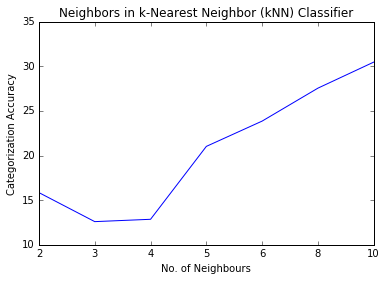

In [250]:
#Plotting the results
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(selectNeighbourScores, label = "Neighbors in k-Nearest Neighbor (kNN) Classifier")
plt.title("Neighbors in k-Nearest Neighbor (kNN) Classifier")

labels = [2,3,4,5,6,8,10]
plt.xticks(np.arange(len(labels)), labels, rotation='horizontal')
# plt.title("Optimal choice of Neighbors in k-Nearest Neighbor (kNN) Classifier")
plt.ylabel('Categorization Accuracy')
plt.xlabel('No. of Neighbours')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### Hence, we choose k = 25 for our nearest neighbor classifier.

In [251]:
print len(testStateTransitionVector), len(trainStateTransitionVector)

19 60


In [252]:
# Submission
# train = np.hstack([trainBagVector, np.array(trainStateTransitionVector)])
# test = np.hstack([testBagVector, np.array(testStateTransitionVector)])
# params = {'neighbours':5}
# neighbours = params['neighbours']
# neigh = KNeighborsClassifier(n_neighbors=neighbours)
# YPred = neigh.fit(train, YTrain).predict(test)
# # writePredictedLabelFile(YPred)
# UseChallenge3Predictions(YPred)

### Selection of Parameters for Random Forest

In [253]:
selectRandomForestScores = []

params = {'trees':500, 'criterion':'entropy','random_state':1000}
score = stratifiedKFoldVal(train, YTrain, classifyRandomForestClassifier, params)
print score
selectRandomForestScores.append(score)

params = {'trees':1000, 'criterion':'entropy','random_state':1000}
score = stratifiedKFoldVal(train, YTrain, classifyRandomForestClassifier, params)
print score
selectRandomForestScores.append(score)

params = {'trees':500, 'criterion':'gini','random_state':1000}
score = stratifiedKFoldVal(train, YTrain, classifyRandomForestClassifier, params)
print score
selectRandomForestScores.append(score)

params = {'trees':1000, 'criterion':'gini','random_state':1000}
score = stratifiedKFoldVal(train, YTrain, classifyRandomForestClassifier, params)
print score
selectRandomForestScores.append(score)

print selectRandomForestScores

26.5357142857
26.5357142857
28.0238095238
29.2738095238
[26.53571428571429, 26.53571428571429, 28.023809523809526, 29.273809523809526]


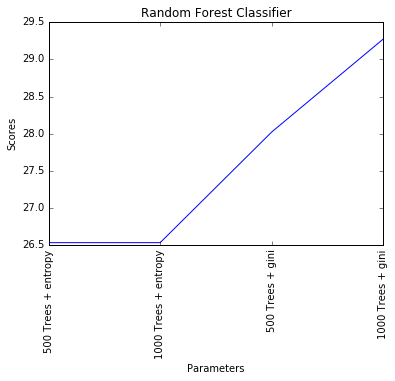

In [254]:
#Plotting the results
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(selectRandomForestScores, label = "Random Forest Classifier")
plt.title("Random Forest Classifier")

labels = ['500 Trees + entropy', '1000 Trees + entropy', '500 Trees + gini', '1000 Trees + gini']

# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(np.arange(len(labels)), labels, rotation='vertical')

plt.ylabel('Scores')
plt.xlabel('Parameters')
# Place a legend to the right of this smaller figure.
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### Hence, we choose 1000 Trees + Gini as a criterion for our Random Forest classifier.

In [255]:
# Submission
# params = {'trees':150, 'criterion':'entropy','random_state':None}
# trees = params['trees']
# crit = params['criterion']
# seed = params['random_state']
# clf = RandomForestClassifier(n_estimators=trees,criterion=crit,random_state=seed)
# clf.fit(trainBagVector, YTrain)
# YPred = clf.predict(testBagVector)

### Selection of Kernel for Multi Class SVM

In [256]:
selectKernelScores = []

params = {'kernel':'poly'}
score = stratifiedKFoldVal(train, YTrain, classifyMultiClassSVMClassifier, params)
print score
selectKernelScores.append(score)

params = {'kernel':'linear'}
score = stratifiedKFoldVal(train, YTrain, classifyMultiClassSVMClassifier, params)
print score
selectKernelScores.append(score)

params = {'kernel':'rbf'}
score = stratifiedKFoldVal(train, YTrain, classifyMultiClassSVMClassifier, params)
print score
selectKernelScores.append(score)

31.7976190476
21.9523809524
38.2976190476


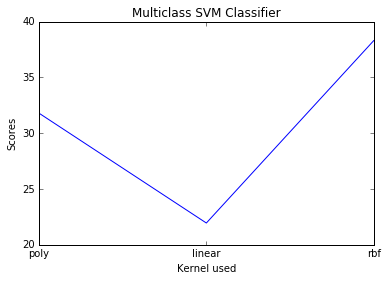

In [258]:
#Plotting the results
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(selectKernelScores, label = "Multiclass SVM Classifier")

labels = ['poly','linear','rbf']
plt.title("Multiclass SVM Classifier")
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(np.arange(len(labels)), labels, rotation='horizontal')

plt.ylabel('Scores')
plt.xlabel('Kernel used')
# Place a legend to the right of this smaller figure.
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### Hence, we choose rbf for our SVM classifier.

In [259]:
# params = {'kernel':'rbf'}
# ker = params['kernel']
# YPred = svm.SVC(kernel=ker).fit(trainBagVector, YTrain).predict(testBagVector)
# writePredictedLabelFile(YPred)

### Logistic Regression

In [262]:
# params = {'multi':False}
# train = tfidfTrain
# score = stratifiedKFoldVal(train, YTrain, classifyLogisticRegression, params)
# print score
train = XTrainAllFeatures
score = stratifiedKFoldVal(train, YTrain, classifyLogisticRegression, params)
print score

19.5952380952


In [261]:
params = {'multi':True}
train = trainStateTransitionVector
score = stratifiedKFoldVal(train, YTrain, classifyLogisticRegression, params)
print score

27.9047619048


In [ ]:
# LogReg = linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None)
# LogReg.fit(trainBagVector, YTrain)
# YPred = LogReg.predict(testBagVector)
# # writePredictedLabelFile(YPred)

### Define the parameters for Adaboost and use it on different training dataset

In [268]:
train = XTrainAllFeatures
params = {'max_depth':1, 'algorithm':'SAMME', 'n_estimators':200}
score = stratifiedKFoldVal(train, YTrain, classifyAdaboostClassifier, params)
print score

21.380952381


In [269]:
train = XTrainAllFeatures
params = {'max_depth':10, 'algorithm':'SAMME', 'n_estimators':500}
score = stratifiedKFoldVal(train, YTrain, classifyAdaboostClassifier, params)
print score

19.7142857143


In [270]:
# # Submission
# params = {'max_depth':10, 'algorithm':'SAMME', 'n_estimators':500}
# train = tfidfTrain
# test = tfidfTest
# depth = params['max_depth']
# algo = params['algorithm']
# estimators = params['n_estimators']

# # Create and fit an AdaBoosted decision tree
# bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth = depth),
#                      algorithm = algo,
#                      n_estimators=estimators)

# bdt.fit(train, YTrain)
# YPred = bdt.predict(test)
# # writePredictedLabelFile(YPred)

### Selection of Parameters for Neural Networks

In [274]:
train = XTrainAllFeatures
# params = {'activation':'Rectifier', 'units':100, 'rate':0.02, 'iter':10}
params = {'activation':'Tanh', 'actLastLayer':'Softmax', 'rule':'momentum', 'units':100, 'rate':0.002, 'iter':10}
score = stratifiedKFoldVal(train, YTrain, classifyNeuralNetworkClassifier, params)
print score

13.0119047619


In [272]:
train = XTrainAllFeatures
# params = {'activation':'Rectifier', 'units':100, 'rate':0.02, 'iter':10}
params = {'activation':'Tanh', 'actLastLayer':'Softmax', 'rule':'sgd', 'units':100, 'rate':0.002, 'iter':10}
score = stratifiedKFoldVal(train, YTrain, classifyNeuralNetworkClassifier, params)
print score

19.4404761905


In [273]:
train = XTrainAllFeatures
params = {'activation':'Sigmoid', 'actLastLayer':'Softmax', 'rule':'rmsprop', 'units':100, 'rate':0.002, 'iter':10}
score = stratifiedKFoldVal(train, YTrain, classifyNeuralNetworkClassifier, params)
print score

19.8571428571


In [ ]:
# # Submission
# tr = trainBagVector
# te = testBagVector
# params = {'activation':'Tanh', 'actLastLayer':'Softmax', 'rule':'adagrad', 'units':100, 'rate':0.002, 'iter':10}
# activation = params['activation']
# actLastLayer = params['actLastLayer']
# rule = params['rule']
# noOfUnits = params['units']
# rate = params['rate']
# noOfIter = params['iter']
# nn = Classifier(layers=[Layer(activation, units=noOfUnits),Layer(actLastLayer)], learning_rule=rule,
#         learning_rate=0.02,
#         n_iter=10)
# nn.fit(tr, YTrain)
# YPred = nn.predict(te)
# # writePredictedLabelFile(YPred)

### Get features in format for Models of NLTK Classify 

In [ ]:
def featNLTKClassify(samples, phase):
    featureVectors = vectorizer.get_feature_names()
    nltkClassifySamples = []

    for i in xrange(len(samples)):
        t = samples[i]
        lstFuncCalls = t.split()
        wordOccDict = {}
        for j in xrange(len(featureVectors)):
             wordOccDict[featureVectors[j]] = lstFuncCalls.count(featureVectors[j])
        if phase == 'train':
            nltkClassifySamples.append((wordOccDict, YTrain[i]))
        else:
            nltkClassifySamples.append(wordOccDict)

    return nltkClassifySamples

In [ ]:
nltkClassifyTrain = featNLTKClassify(trainSamples, 'train')
nltkClassifyTest = featNLTKClassify(testSamples, 'test')

### Nave Baiyes Classifier

In [ ]:
tr = nltkClassifyTrain
te = nltkClassifyTest
classifier = nltk.classify.NaiveBayesClassifier.train(tr)
sorted(classifier.labels())

In [ ]:
classifier.classify_many(te)

classifier.show_most_informative_features()
# print nltk.classify.accuracy(classifier, te)*100

### Maximum Entropy Classifier

In [ ]:
from nltk.classify import maxent
tr = nltkClassifyTrain
te = nltkClassifyTest
classifierME = maxent.MaxentClassifier.train(tr, bernoulli=False, encoding=encoding, trace=0)
classifierME.classify_many(te)

### Decision Tree Classifier

In [ ]:
tr = nltkClassifyTrain
te = nltkClassifyTest

classifier = nltk.classify.DecisionTreeClassifier.train(tr, entropy_cutoff=0,support_cutoff=0)
sorted(classifier.labels())
print(classifier)
classifier.classify_many(te)

### Graphs depicting Categorization Accuracy scores on KFold Stratified Validation on Train data for:

In [ ]:
selectRandomForestScores = []
selectKernelScores = []
selectNeighbourScores = []

train = trainBagVector

params = {'trees':1000, 'criterion':'gini','random_state':1000}
score = stratifiedKFoldVal(train, YTrain, classifyRandomForestClassifier, params)
print score
selectRandomForestScores.append(score)

params = {'neighbours':25}
score = stratifiedKFoldVal(train, YTrain, classifyKNNClassifier, params)
print score
selectNeighbourScores.append(score)

params = {'kernel':'linear'}
score = stratifiedKFoldVal(train, YTrain, classifyMultiClassSVMClassifier, params)
print score
selectKernelScores.append(score)



train = tfidfTrain

params = {'trees':1000, 'criterion':'gini','random_state':1000}
score = stratifiedKFoldVal(train, YTrain, classifyRandomForestClassifier, params)
print score
selectRandomForestScores.append(score)

params = {'neighbours':25}
score = stratifiedKFoldVal(train, YTrain, classifyKNNClassifier, params)
print score
selectNeighbourScores.append(score)

params = {'kernel':'rbf'}
score = stratifiedKFoldVal(train, YTrain, classifyMultiClassSVMClassifier, params)
print score
selectKernelScores.append(score)


train = np.array(trainStateTransitionVector)

params = {'trees':1000, 'criterion':'gini','random_state':1000}
score = stratifiedKFoldVal(train, YTrain, classifyRandomForestClassifier, params)
print score
selectRandomForestScores.append(score)

params = {'neighbours':25}
score = stratifiedKFoldVal(train, YTrain, classifyKNNClassifier, params)
print score
selectNeighbourScores.append(score)


params = {'kernel':'rbf'}
score = stratifiedKFoldVal(train, YTrain, classifyMultiClassSVMClassifier, params)
print score
selectKernelScores.append(score)


train = np.hstack([trainBagVector, np.array(trainStateTransitionVector)])

params = {'trees':1000, 'criterion':'gini','random_state':1000}
score = stratifiedKFoldVal(train, YTrain, classifyRandomForestClassifier, params)
print score
selectRandomForestScores.append(score)

params = {'neighbours':25}
score = stratifiedKFoldVal(train, YTrain, classifyKNNClassifier, params)
print score
selectNeighbourScores.append(score)

params = {'kernel':'rbf'}
score = stratifiedKFoldVal(train, YTrain, classifyMultiClassSVMClassifier, params)
print score
selectKernelScores.append(score)



print selectRandomForestScores
print selectKernelScores
print selectNeighbourScores

In [ ]:
#Plotting the results
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(selectRandomForestScores, label = "Random Forest Classifier")
plt.plot(selectKernelScores, label = "Multiclass Linear SVM Classifier")
plt.plot(selectNeighbourScores, label = "KNN Classifier")

labels = ['Bag of Words', 'TF-IDF', 'State Transitions', 'Stacked Features 1 & 3']

# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(np.arange(len(labels)), labels, rotation='vertical')

plt.ylabel('Scores')
plt.xlabel('Feature Encoding used')
# Place a legend to the right of this smaller figure.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Final evaluation results on Kaggle

### Bar graph depicting Public vs Private Categorization Accuracy Scores on the different Models.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
N = 8
publicScore = (80.453, 75.637, 79.887, 80.737, 81.586, 80.170, 80.170, 79.887)
privateScore = (84.136, 80.170, 83.569, 83.003, 83.286, 83.003, 83.003, 83.569)
modelNames = ('RF(50T, Entropy)+Bag of Words', 'RF(150T, Entropy)+TF-IDF', 'RF(50T, Entropy) + State Transition', 
              'KNN(5) +Bag of Words', 'KNN(5) + TF-IDF', 'KNN(5) + State Transition',
              'Stack: KNN(5) + ST + BoW', 'Stack: RF(50T, Entropy) + ST + BoW')

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, publicScore, width, color='m')

rects2 = ax.bar(ind + width, privateScore, width, color='c')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Evaluations of submissions using Categorization Accuracy.')
ax.set_xticks(ind + width)
ax.set_xticklabels(modelNames,  rotation='vertical')
ax.set_ylim(75,85)

# def autolabel(rects):
#     # attach some text labels
#     for rect in rects:
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#                 '%d' % int(height),
#                 ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)

# Place a legend to the right of this smaller figure.
ax.legend((rects1[0], rects2[0]), ('Public Scores', 'Private Scores'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Hence we conclude that the best model is kNN using TF-IDF as features !

## Geo Visualization

In [319]:
def reverseMapLabels(classNo):
    if className == 0:
        return 'Conscientiousness'
    elif className == 1:
        return 'Extrovert'
    elif className == 2:
        return 'Agreeable'
    elif className == 3:
        return 'Empathetic'
    elif className == 4:
        return 'Novelty Seeking'
    elif className == 5:
        return 'Perfectionist'
    elif className == 6:
        return 'Rigid'
    elif className == 7:
        return 'Impulsive'
    elif className == 8:
        return 'Psychopath'
    elif className == 9:
        return 'Obsessive'
    else:
        return None


In [363]:
import string
import matplotlib.cm as cm

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

import pandas as pd

def GeoPlot(geo_longitude, geo_latitude, labels):

    fig = plt.figure(figsize=(20,10))
    
    raw_data = {'latitude': geo_latitude,
            'longitude': geo_longitude}

    df = pd.DataFrame(raw_data, columns = ['latitude', 'longitude'])

    
    totSampleLen = len(labels)
#     print totSampleLen
    colors = ['blue', 'beige', 'red', 'green', 'magenta', 'yellow', 'cyan', 'aquamarine', 'azure', 'darkkhaki']
    
    m = Basemap(projection='gall',lon_0=0,lat_0=0,resolution='i')
#     x1,y1=map(geo_longitude, geo_latitude)
    x1,y1 = map(df['longitude'].values, df['latitude'].values)


    m.drawmapboundary(fill_color='black') # fill to edge
    m.drawcountries()
    m.fillcontinents(color='white',lake_color='black')
    
#     m.scatter(x1, y1, marker='D',color='m', s=2)
    for i in xrange(totSampleLen):
        for k in xrange(10):
            if labels[i] == k:
#                 print x1[i], y1[i]
#                 print colors[k]
#                 m.scatter(x1[i], y1[i], marker='D',color=colors[k], s=2)
                m.plot(x1[i], y1[i], 'ro', color=colors[k]) #'ro', markersize=6)

    
    for k in xrange(10):
        m.scatter(0,0, marker='D',color=colors[k], s=2, label=reverseMapLabels(k))
    
    plt.title("Geo-tagging Personality Types for Twitter Users")
    # Place a legend to the right of this smaller figure.
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


### Visualize Personality Types based on location of user tweets.

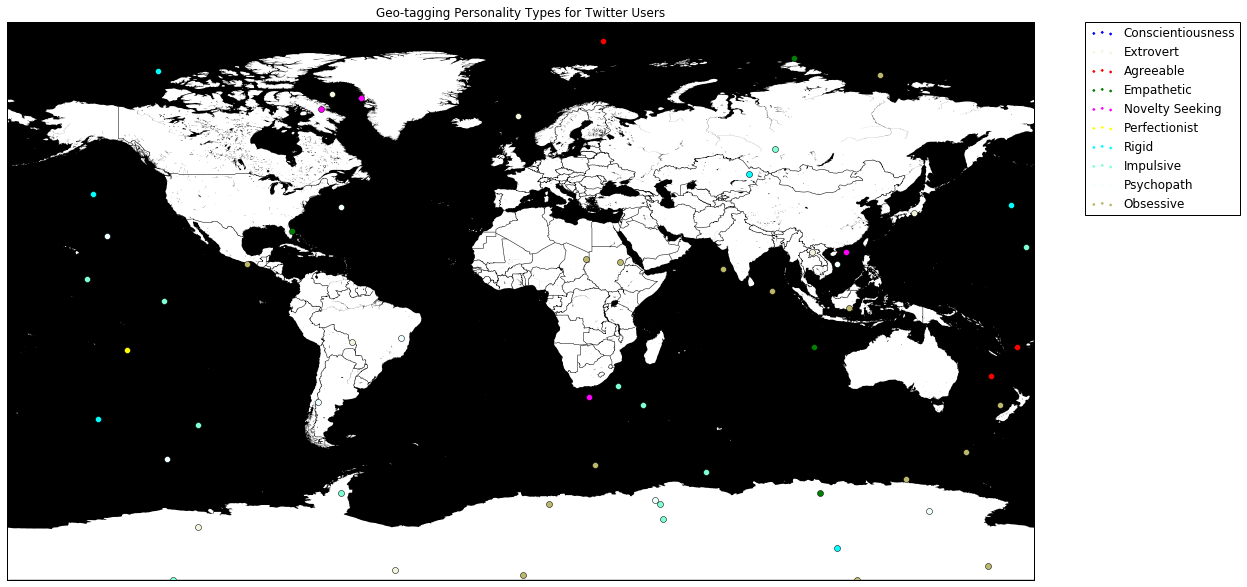

In [365]:
lon = np.random.random_integers(-180,180,60)
lat = np.random.random_integers(-90,90,60)
geo_latitude = lat
geo_longitude = lon
GeoPlot(geo_longitude, geo_latitude, YTrain[0:60])

In [334]:
# import string
# import matplotlib.cm as cm

# from mpl_toolkits.basemap import Basemap
# import matplotlib.pyplot as plt

# fig = plt.figure()

# m.scatter(x1,y1,s=sizes,c=cols, marker="o",cmap=cm.cool,alpha=0.7)
# m.scatter(x1,y1,25,z,cmap=plt.cm.jet,marker='o',edgecolors='none',zorder=10)
# m.hexbin(x1,y1,gridsize=180,bins='log',cmap=cm.jet,linewidths=0,edgecolors=None,zorder=3,alpha=0.9)

# m.plot(x,y, 'bo', markersize=5)

# c = plt.colorbar(orientation='vertical', shrink = 0.3)
# c.set_label("Personality Types")

# sc = m.scatter(x1,y1,cmap=plt.cm.jet,marker='o',edgecolors='none')
# sc = m.scatter(x,y, c=cols, vmin=0, vmax =35, cmap=cm.jet, s=sizes, edgecolors='none')
# cbar = plt.colorbar(sc, shrink = .5)
# cbar.set_label("Personality Types")



### Geo-tagging Sentiments of Twitter Users

In [372]:
def reverseMapSentiments(classNo):
    if classNo == 0:
        return 'Negative'
    elif classNo == 1:
        return 'Neutral'
    elif classNo == 2:
        return 'Positive'
    else:
        return None

In [380]:
def GeoSentimentPlot(geo_longitude, geo_latitude, sentiments):

    fig = plt.figure(figsize=(20,10))
    
    raw_data = {'latitude': geo_latitude,
            'longitude': geo_longitude}

    df = pd.DataFrame(raw_data, columns = ['latitude', 'longitude'])

    
    totSampleLen = len(sentiments)
    colors = ['red', 'blue', 'green']
    
    negLimit = 0
    posLimit = 0
    
    m = Basemap(projection='gall',lon_0=0,lat_0=0,resolution='i')
    x1,y1 = map(df['longitude'].values, df['latitude'].values)


    m.drawmapboundary(fill_color='black')
    m.drawcountries()
    m.fillcontinents(color='white',lake_color='black')
    
    for i in xrange(totSampleLen):
#         print sentiments[i]
        if sentiments[i] < negLimit:
            m.plot(x1[i], y1[i], 'ro', color=colors[0])
        elif sentiments[i] >= negLimit and sentiments[i] <= posLimit:
            m.plot(x1[i], y1[i], 'ro', color=colors[1])
        elif sentiments[i] > posLimit:
            m.plot(x1[i], y1[i], 'ro', color=colors[2])

    
    for k in xrange(3):
        m.scatter(0,0, marker='D',color=colors[k], s=2, label=reverseMapSentiments(k))
    
    plt.title("Geo-tagging Sentiments of Twitter Users")
    # Place a legend to the right of this smaller figure.
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


### Visualize Sentiment of user tweets based on location.

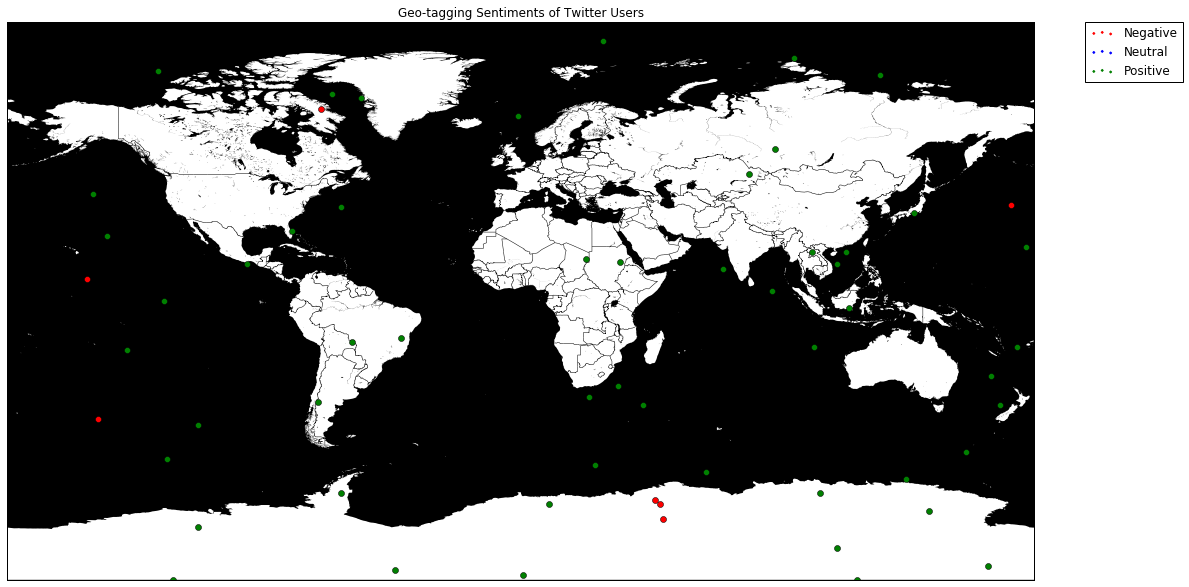

In [381]:
GeoSentimentPlot(geo_longitude, geo_latitude, XTrainSentiment[0:60])